## Import Libraries and Data

In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


from catboost import CatBoostRegressor, Pool, cv
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [152]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data exploration

In [153]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [154]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [155]:
target_variable = 'SalePrice'

## Variables Correlation

#### Distribution of target variable

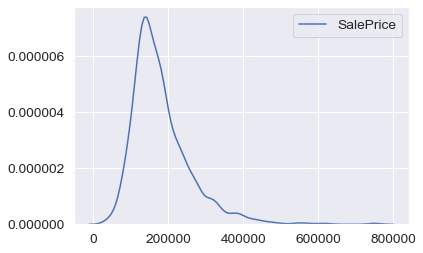

In [156]:
sns.kdeplot(train[target_variable])

#### Check the correlation of variables

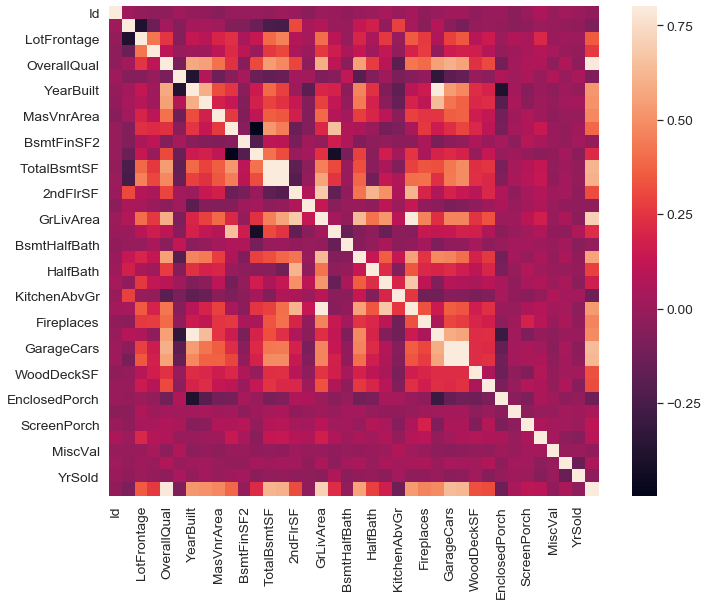

In [157]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

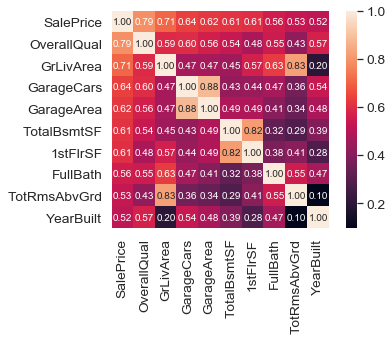

In [158]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, target_variable)[target_variable].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Relation between Living Area and Sales Price

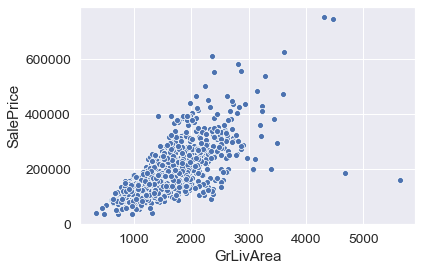

In [159]:
sns.scatterplot(train['GrLivArea'],train[target_variable])

#### Relation between Overall material and finish quality and Sales Price

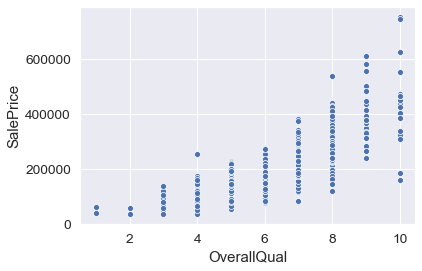

In [160]:
sns.scatterplot(train['OverallQual'],train[target_variable])

## Missing Values

In [161]:
# Drop any column with more than 10% missing values
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [162]:
cols_to_del = missing_data[missing_data['Total'] > 0].index

In [163]:
#Delete columns in dataset
filtered_columns = [col for col in train.columns if col not in cols_to_del]
train_ft = train[filtered_columns]

## Preparing dataset for regression

#### Filling null values

In [164]:
train_ft = train_ft.fillna(train_ft.median())

#### Transforming categorical variables in dummy variables

In [165]:
# train_ft = pd.get_dummies(train_ft)

#### Categorial features selection

In [166]:
print(train_ft.dtypes)

Id                int64
MSSubClass        int64
MSZoning         object
LotArea           int64
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
OverallQual       int64
OverallCond       int64
YearBuilt         int64
YearRemodAdd      int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
ExterQual        object
ExterCond        object
Foundation       object
BsmtFinSF1        int64
BsmtFinSF2        int64
BsmtUnfSF         int64
TotalBsmtSF       int64
                  ...  
CentralAir       object
1stFlrSF          int64
2ndFlrSF          int64
LowQualFinSF      int64
GrLivArea         int64
BsmtFullBath      int64
BsmtHalfBath      int64
FullBath          int64
HalfBath          int64
BedroomAbvGr      int64
KitchenAbvGr    

In [167]:
categorical_features_indices = np.where(train_ft.dtypes == 'object')[0]

#### Train and test split for the train dataset

In [168]:
independent_variables = [col for col in train_ft.columns if col != target_variable]
X_train, X_test, y_train, y_test = train_test_split(train_ft[independent_variables], train_ft[target_variable], test_size=0.2, random_state=0)

#### Feature scaling

In [169]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

## Regression (CatBoost)

#### Model training

In [170]:
#Model paramaters
model = CatBoostRegressor()

#Fit model
model.fit(X_train, 
          y_train,
         cat_features=categorical_features_indices,
        eval_set=(X_test, y_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True)

Learning rate set to 0.04745


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76180.0881897	test: 80835.6685495	best: 80835.6685495 (0)	total: 53ms	remaining: 52.9s
1:	learn: 74254.6621628	test: 78932.7537473	best: 78932.7537473 (1)	total: 104ms	remaining: 51.9s
2:	learn: 71979.6230415	test: 76752.7489501	best: 76752.7489501 (2)	total: 160ms	remaining: 53.1s
3:	learn: 69913.9820957	test: 74718.9460184	best: 74718.9460184 (3)	total: 219ms	remaining: 54.6s
4:	learn: 67848.7120907	test: 72581.2745103	best: 72581.2745103 (4)	total: 278ms	remaining: 55.4s
5:	learn: 66011.1818232	test: 70614.3527768	best: 70614.3527768 (5)	total: 330ms	remaining: 54.6s
6:	learn: 64174.3512831	test: 68838.5520884	best: 68838.5520884 (6)	total: 380ms	remaining: 53.9s
7:	learn: 62417.9361752	test: 67033.2470679	best: 67033.2470679 (7)	total: 426ms	remaining: 52.8s
8:	learn: 60887.2908362	test: 65460.1724223	best: 65460.1724223 (8)	total: 473ms	remaining: 52.1s
9:	learn: 59477.2136723	test: 64245.3367451	best: 64245.3367451 (9)	total: 522ms	remaining: 51.6s
10:	learn: 58076.3667

85:	learn: 22364.0485467	test: 31068.0716912	best: 31068.0716912 (85)	total: 6.12s	remaining: 1m 5s
86:	learn: 22236.6121960	test: 31002.2328751	best: 31002.2328751 (86)	total: 6.17s	remaining: 1m 4s
87:	learn: 22127.8057511	test: 30947.2943488	best: 30947.2943488 (87)	total: 6.22s	remaining: 1m 4s
88:	learn: 22052.5970452	test: 30909.0689508	best: 30909.0689508 (88)	total: 6.29s	remaining: 1m 4s
89:	learn: 21969.0295730	test: 30815.3895576	best: 30815.3895576 (89)	total: 6.41s	remaining: 1m 4s
90:	learn: 21843.7729471	test: 30718.1973749	best: 30718.1973749 (90)	total: 6.48s	remaining: 1m 4s
91:	learn: 21734.6066661	test: 30649.7280069	best: 30649.7280069 (91)	total: 6.55s	remaining: 1m 4s
92:	learn: 21613.4921899	test: 30556.1334462	best: 30556.1334462 (92)	total: 6.61s	remaining: 1m 4s
93:	learn: 21533.4599791	test: 30564.6543460	best: 30556.1334462 (92)	total: 6.66s	remaining: 1m 4s
94:	learn: 21432.0734245	test: 30490.3294179	best: 30490.3294179 (94)	total: 6.71s	remaining: 1m 3s


167:	learn: 17859.0265945	test: 28537.4180473	best: 28537.4180473 (167)	total: 12.7s	remaining: 1m 2s
168:	learn: 17813.7956766	test: 28518.7460256	best: 28518.7460256 (168)	total: 12.8s	remaining: 1m 2s
169:	learn: 17777.9017276	test: 28514.3388264	best: 28514.3388264 (169)	total: 12.8s	remaining: 1m 2s
170:	learn: 17767.8434585	test: 28500.8920607	best: 28500.8920607 (170)	total: 12.9s	remaining: 1m 2s
171:	learn: 17753.2829547	test: 28474.1702855	best: 28474.1702855 (171)	total: 13s	remaining: 1m 2s
172:	learn: 17734.4127142	test: 28493.5595109	best: 28474.1702855 (171)	total: 13.1s	remaining: 1m 2s
173:	learn: 17706.4758071	test: 28489.1200542	best: 28474.1702855 (171)	total: 13.1s	remaining: 1m 2s
174:	learn: 17690.8582135	test: 28483.9541137	best: 28474.1702855 (171)	total: 13.2s	remaining: 1m 2s
175:	learn: 17643.7914064	test: 28465.2659100	best: 28465.2659100 (175)	total: 13.3s	remaining: 1m 2s
176:	learn: 17625.7572482	test: 28440.3889044	best: 28440.3889044 (176)	total: 13.4s

250:	learn: 15847.1661290	test: 27990.2385101	best: 27990.2385101 (250)	total: 19.4s	remaining: 57.9s
251:	learn: 15829.6474646	test: 27980.1218706	best: 27980.1218706 (251)	total: 19.5s	remaining: 57.8s
252:	learn: 15807.8062689	test: 27991.0381813	best: 27980.1218706 (251)	total: 19.6s	remaining: 57.7s
253:	learn: 15760.6223368	test: 27981.5107365	best: 27980.1218706 (251)	total: 19.6s	remaining: 57.6s
254:	learn: 15756.9810515	test: 27981.3946836	best: 27980.1218706 (251)	total: 19.7s	remaining: 57.5s
255:	learn: 15721.0504268	test: 27985.1755395	best: 27980.1218706 (251)	total: 19.8s	remaining: 57.4s
256:	learn: 15687.5910421	test: 27985.2466976	best: 27980.1218706 (251)	total: 19.8s	remaining: 57.4s
257:	learn: 15685.4276506	test: 27985.3238858	best: 27980.1218706 (251)	total: 19.9s	remaining: 57.3s
258:	learn: 15652.3110334	test: 27969.0277450	best: 27969.0277450 (258)	total: 20s	remaining: 57.3s
259:	learn: 15624.3912819	test: 27967.2640810	best: 27967.2640810 (259)	total: 20.1s

331:	learn: 14197.2216934	test: 27711.8327507	best: 27692.4834287 (326)	total: 25.4s	remaining: 51.2s
332:	learn: 14185.9674358	test: 27710.9340657	best: 27692.4834287 (326)	total: 25.5s	remaining: 51.1s
333:	learn: 14176.5117357	test: 27702.4077202	best: 27692.4834287 (326)	total: 25.6s	remaining: 51s
334:	learn: 14175.9549054	test: 27702.3872859	best: 27692.4834287 (326)	total: 25.6s	remaining: 50.9s
335:	learn: 14144.8116377	test: 27702.4309340	best: 27692.4834287 (326)	total: 25.7s	remaining: 50.8s
336:	learn: 14130.0248493	test: 27694.7604169	best: 27692.4834287 (326)	total: 25.8s	remaining: 50.7s
337:	learn: 14098.8312152	test: 27719.1049608	best: 27692.4834287 (326)	total: 25.9s	remaining: 50.7s
338:	learn: 14071.1368802	test: 27712.0529534	best: 27692.4834287 (326)	total: 26s	remaining: 50.6s
339:	learn: 14065.0109746	test: 27704.9333791	best: 27692.4834287 (326)	total: 26s	remaining: 50.5s
340:	learn: 14062.2828842	test: 27699.8272925	best: 27692.4834287 (326)	total: 26.1s	rem

412:	learn: 12946.5687695	test: 27463.3168975	best: 27463.3168975 (412)	total: 31.8s	remaining: 45.2s
413:	learn: 12943.5903066	test: 27449.3236494	best: 27449.3236494 (413)	total: 31.9s	remaining: 45.2s
414:	learn: 12940.0560441	test: 27459.2292717	best: 27449.3236494 (413)	total: 32s	remaining: 45.1s
415:	learn: 12939.5483759	test: 27459.2102435	best: 27449.3236494 (413)	total: 32.1s	remaining: 45.1s
416:	learn: 12924.5369549	test: 27457.1392399	best: 27449.3236494 (413)	total: 32.2s	remaining: 45s
417:	learn: 12921.7715713	test: 27452.3921508	best: 27449.3236494 (413)	total: 32.3s	remaining: 44.9s
418:	learn: 12920.5913440	test: 27452.3466858	best: 27449.3236494 (413)	total: 32.3s	remaining: 44.8s
419:	learn: 12907.5440093	test: 27451.4765565	best: 27449.3236494 (413)	total: 32.4s	remaining: 44.8s
420:	learn: 12898.4717915	test: 27442.8319927	best: 27442.8319927 (420)	total: 32.6s	remaining: 44.8s
421:	learn: 12894.2701461	test: 27441.6676210	best: 27441.6676210 (421)	total: 32.6s	r

493:	learn: 11970.3858741	test: 27484.3462490	best: 27409.4798194 (439)	total: 38.3s	remaining: 39.2s
494:	learn: 11962.6258375	test: 27481.1269057	best: 27409.4798194 (439)	total: 38.3s	remaining: 39.1s
495:	learn: 11942.7964976	test: 27480.0024849	best: 27409.4798194 (439)	total: 38.4s	remaining: 39s
496:	learn: 11929.2316239	test: 27482.9421782	best: 27409.4798194 (439)	total: 38.5s	remaining: 38.9s
497:	learn: 11913.4230227	test: 27474.2839133	best: 27409.4798194 (439)	total: 38.5s	remaining: 38.9s
498:	learn: 11902.6824487	test: 27467.4210016	best: 27409.4798194 (439)	total: 38.6s	remaining: 38.8s
499:	learn: 11898.4862165	test: 27471.4573505	best: 27409.4798194 (439)	total: 38.8s	remaining: 38.8s
500:	learn: 11884.1015651	test: 27460.2521542	best: 27409.4798194 (439)	total: 38.8s	remaining: 38.7s
501:	learn: 11866.6023612	test: 27433.6284222	best: 27409.4798194 (439)	total: 38.9s	remaining: 38.6s
502:	learn: 11865.7766910	test: 27433.6756310	best: 27409.4798194 (439)	total: 39s	r

575:	learn: 10935.8882782	test: 27273.3624080	best: 27263.7574774 (572)	total: 44.6s	remaining: 32.8s
576:	learn: 10916.1432270	test: 27265.4224014	best: 27263.7574774 (572)	total: 44.6s	remaining: 32.7s
577:	learn: 10893.6777961	test: 27264.4628987	best: 27263.7574774 (572)	total: 44.7s	remaining: 32.7s
578:	learn: 10891.3913878	test: 27264.7940436	best: 27263.7574774 (572)	total: 44.8s	remaining: 32.6s
579:	learn: 10862.8511999	test: 27262.4979555	best: 27262.4979555 (579)	total: 44.9s	remaining: 32.5s
580:	learn: 10853.9745930	test: 27259.3650809	best: 27259.3650809 (580)	total: 44.9s	remaining: 32.4s
581:	learn: 10837.5660166	test: 27259.9071452	best: 27259.3650809 (580)	total: 45s	remaining: 32.3s
582:	learn: 10831.2901930	test: 27253.1516737	best: 27253.1516737 (582)	total: 45s	remaining: 32.2s
583:	learn: 10808.3527705	test: 27260.6833949	best: 27253.1516737 (582)	total: 45.1s	remaining: 32.1s
584:	learn: 10803.8699108	test: 27264.8606258	best: 27253.1516737 (582)	total: 45.2s	r

659:	learn: 10047.3525663	test: 27184.7151742	best: 27173.0426664 (637)	total: 50.8s	remaining: 26.2s
660:	learn: 10033.5068552	test: 27186.4047786	best: 27173.0426664 (637)	total: 50.9s	remaining: 26.1s
661:	learn: 10019.8590576	test: 27189.1154455	best: 27173.0426664 (637)	total: 50.9s	remaining: 26s
662:	learn: 10006.4880015	test: 27189.2531431	best: 27173.0426664 (637)	total: 51s	remaining: 25.9s
663:	learn: 10001.9914298	test: 27190.6938663	best: 27173.0426664 (637)	total: 51.1s	remaining: 25.9s
664:	learn: 9988.5830967	test: 27185.5404522	best: 27173.0426664 (637)	total: 51.2s	remaining: 25.8s
665:	learn: 9974.7945381	test: 27179.4666099	best: 27173.0426664 (637)	total: 51.2s	remaining: 25.7s
666:	learn: 9968.3900526	test: 27177.7287667	best: 27173.0426664 (637)	total: 51.3s	remaining: 25.6s
667:	learn: 9963.5047492	test: 27179.3873013	best: 27173.0426664 (637)	total: 51.4s	remaining: 25.6s
668:	learn: 9960.0628919	test: 27178.9128350	best: 27173.0426664 (637)	total: 51.5s	remain

742:	learn: 9298.3060069	test: 27143.6210854	best: 27138.9680171 (741)	total: 56.7s	remaining: 19.6s
743:	learn: 9288.9459435	test: 27142.0636884	best: 27138.9680171 (741)	total: 56.8s	remaining: 19.5s
744:	learn: 9282.1704332	test: 27139.7534615	best: 27138.9680171 (741)	total: 56.9s	remaining: 19.5s
745:	learn: 9270.2505751	test: 27138.2084009	best: 27138.2084009 (745)	total: 56.9s	remaining: 19.4s
746:	learn: 9265.4277273	test: 27141.1292833	best: 27138.2084009 (745)	total: 57s	remaining: 19.3s
747:	learn: 9255.7789808	test: 27137.3917184	best: 27137.3917184 (747)	total: 57s	remaining: 19.2s
748:	learn: 9245.7784072	test: 27138.8790558	best: 27137.3917184 (747)	total: 57.1s	remaining: 19.1s
749:	learn: 9237.7187444	test: 27142.0118203	best: 27137.3917184 (747)	total: 57.2s	remaining: 19.1s
750:	learn: 9226.0598649	test: 27133.8754554	best: 27133.8754554 (750)	total: 57.2s	remaining: 19s
751:	learn: 9208.8193316	test: 27118.6697952	best: 27118.6697952 (751)	total: 57.3s	remaining: 18

827:	learn: 8530.0130091	test: 27044.8321532	best: 27044.8321532 (827)	total: 1m 2s	remaining: 13s
828:	learn: 8517.6801440	test: 27042.4066702	best: 27042.4066702 (828)	total: 1m 2s	remaining: 12.9s
829:	learn: 8504.2019785	test: 27040.3924370	best: 27040.3924370 (829)	total: 1m 2s	remaining: 12.8s
830:	learn: 8503.3184065	test: 27040.8345615	best: 27040.3924370 (829)	total: 1m 2s	remaining: 12.7s
831:	learn: 8491.8367304	test: 27042.1087809	best: 27040.3924370 (829)	total: 1m 2s	remaining: 12.6s
832:	learn: 8487.1150376	test: 27041.8160610	best: 27040.3924370 (829)	total: 1m 2s	remaining: 12.6s
833:	learn: 8485.2076174	test: 27044.4160318	best: 27040.3924370 (829)	total: 1m 2s	remaining: 12.5s
834:	learn: 8467.7537051	test: 27033.1422001	best: 27033.1422001 (834)	total: 1m 2s	remaining: 12.4s
835:	learn: 8464.4658826	test: 27032.8323885	best: 27032.8323885 (835)	total: 1m 2s	remaining: 12.3s
836:	learn: 8457.7517862	test: 27034.1589196	best: 27032.8323885 (835)	total: 1m 2s	remaining

909:	learn: 7909.0804104	test: 27022.2268823	best: 27014.8583559 (873)	total: 1m 7s	remaining: 6.69s
910:	learn: 7906.8785333	test: 27021.3319886	best: 27014.8583559 (873)	total: 1m 7s	remaining: 6.62s
911:	learn: 7903.9492888	test: 27017.5422432	best: 27014.8583559 (873)	total: 1m 7s	remaining: 6.54s
912:	learn: 7890.8974675	test: 27016.0778686	best: 27014.8583559 (873)	total: 1m 7s	remaining: 6.47s
913:	learn: 7887.9270433	test: 27017.3278970	best: 27014.8583559 (873)	total: 1m 7s	remaining: 6.39s
914:	learn: 7886.9439445	test: 27016.7891740	best: 27014.8583559 (873)	total: 1m 8s	remaining: 6.32s
915:	learn: 7884.9123155	test: 27014.3460634	best: 27014.3460634 (915)	total: 1m 8s	remaining: 6.24s
916:	learn: 7880.2407532	test: 27012.9280209	best: 27012.9280209 (916)	total: 1m 8s	remaining: 6.17s
917:	learn: 7879.9459148	test: 27010.2909331	best: 27010.2909331 (917)	total: 1m 8s	remaining: 6.09s
918:	learn: 7876.3815337	test: 27010.3152555	best: 27010.2909331 (917)	total: 1m 8s	remaini

990:	learn: 7518.1955166	test: 26952.3255933	best: 26952.3255933 (990)	total: 1m 12s	remaining: 661ms
991:	learn: 7511.5786466	test: 26950.5290875	best: 26950.5290875 (991)	total: 1m 12s	remaining: 588ms
992:	learn: 7509.5795586	test: 26949.0248330	best: 26949.0248330 (992)	total: 1m 12s	remaining: 514ms
993:	learn: 7509.3373996	test: 26948.5738652	best: 26948.5738652 (993)	total: 1m 12s	remaining: 441ms
994:	learn: 7503.0424641	test: 26948.5174382	best: 26948.5174382 (994)	total: 1m 13s	remaining: 367ms
995:	learn: 7502.7380599	test: 26948.1625598	best: 26948.1625598 (995)	total: 1m 13s	remaining: 294ms
996:	learn: 7495.2164719	test: 26949.2438704	best: 26948.1625598 (995)	total: 1m 13s	remaining: 220ms
997:	learn: 7492.5809450	test: 26949.6342706	best: 26948.1625598 (995)	total: 1m 13s	remaining: 147ms
998:	learn: 7492.2189420	test: 26949.4662719	best: 26948.1625598 (995)	total: 1m 13s	remaining: 73.4ms
999:	learn: 7490.1587608	test: 26953.9556618	best: 26948.1625598 (995)	total: 1m 

#### Evaluate the regression

In [171]:
y_pred = model.predict(X_test)

In [172]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 15592.642877264752
Mean Squared Error: 726203465.3493567
Root Mean Squared Error: 26948.162559799075


## Run algorithm os test dataset

#### Prepare test dataset for the regression

In [173]:
#Transform categorical in dummy variables
# test_ft = pd.get_dummies(test)
test_ft = test

#Select only the columns in the training dataset
ind_var_is_test = [col for col in independent_variables if col in test_ft.columns]
ind_var_is_not_test = [col for col in independent_variables if col not in test_ft.columns]
test_ft = test_ft[ind_var_is_test]
for col in ind_var_is_not_test:
    test_ft[col] = 0

#Fill null values
test_ft = test_ft.fillna(test_ft.median())

# Get columns with null values to fill 
total_test = pd.DataFrame(test_ft.isnull().sum().sort_values(ascending=False)).reset_index()
total_test.columns = ['variable','total']
cols_fill_test = total_test[total_test['total'] > 0]['variable']

# Fill categorical values with model
for col in cols_fill_test:
    test_ft = test_ft.fillna(test_ft[col].mode()[0])


#Apply the standard scaler for the test dataset
# test_ft = sc.fit_transform(test_ft)- 

In [174]:
pred = model.predict(test_ft)

In [175]:
submission = pd.DataFrame(test['Id'])
submission['SalePrice'] = pred
submission.to_csv('submission.csv', index=False)